In [1]:
# Treatment Outcomes Analysis

import sys
import os

# Add the parent directory to sys.path
notebook_dir = os.path.abspath(os.path.dirname('__file__'))
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(parent_dir)

# If the previous approach did not work, you can use this instead
# ================================================================
# Explicitly define the path to the project root
# project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# sys.path.append(project_root)
# ================================================================

# Now we can import from src
from src.healthcare_utils import *


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
## 1. Data Loading and Preparation

# Load the dataset
df = load_diabetes_data()

In [3]:
# Create necessary categories
df = create_glucose_categories(df)
df['RiskScore'] = calculate_risk_score(df)
df['RiskGroup'] = pd.qcut(df['RiskScore'], q=6,
                          labels=['Low', 'Medium', 'High', 'Very High'],
                         duplicates = 'drop')

## 2. Clinical Metrics Analysis

# Get metrics comparison
metrics_comparison = get_clinical_metrics_comparison(df)
print("\nClinical Metrics Comparison:")
print(metrics_comparison)


Clinical Metrics Comparison:
               Diabetic  Non-Diabetic  Difference_%
Glucose          141.26        109.98         28.44
BMI               35.14         30.30         15.97
BloodPressure     70.82         68.18          3.87


In [4]:
## 3. Glucose Control Analysis

glucose_analysis = df.groupby('GlucoseControl', observed=True).agg({
    'Outcome': ['count', lambda x: (x == 1).mean() * 100]
}).round(2)

print("\nGlucose Control Analysis:")
print(glucose_analysis)


Glucose Control Analysis:
               Outcome           
                 count <lambda_0>
GlucoseControl                   
Low                 11       0.00
Normal             181       7.73
Pre-diabetic       274      27.74
Diabetic           297      59.26


In [5]:
## 4. Treatment Outcomes by Risk Group

outcomes_by_risk = df.groupby('RiskGroup', observed=True).agg({
    'Outcome': ['count', lambda x: (x == 1).mean() * 100]
}).round(2)

print("\nOutcomes by Risk Group:")
print(outcomes_by_risk)


Outcomes by Risk Group:
          Outcome           
            count <lambda_0>
RiskGroup                   
Low           362      15.75
Medium        255      40.00
High          119      68.91
Very High      32      84.38


In [6]:
## 5. Clinical Correlations

clinical_vars = ['Glucose', 'BloodPressure', 'Insulin', 'BMI', 'Outcome']
clinical_correlations = df[clinical_vars].corr()['Outcome']
print("\nClinical Variable Correlations with Outcome:")
print(clinical_correlations.sort_values(ascending=False))


Clinical Variable Correlations with Outcome:
Outcome          1.000000
Glucose          0.466581
BMI              0.292695
Insulin          0.130548
BloodPressure    0.065068
Name: Outcome, dtype: float64


## 6. Treatment Effectiveness Visualization

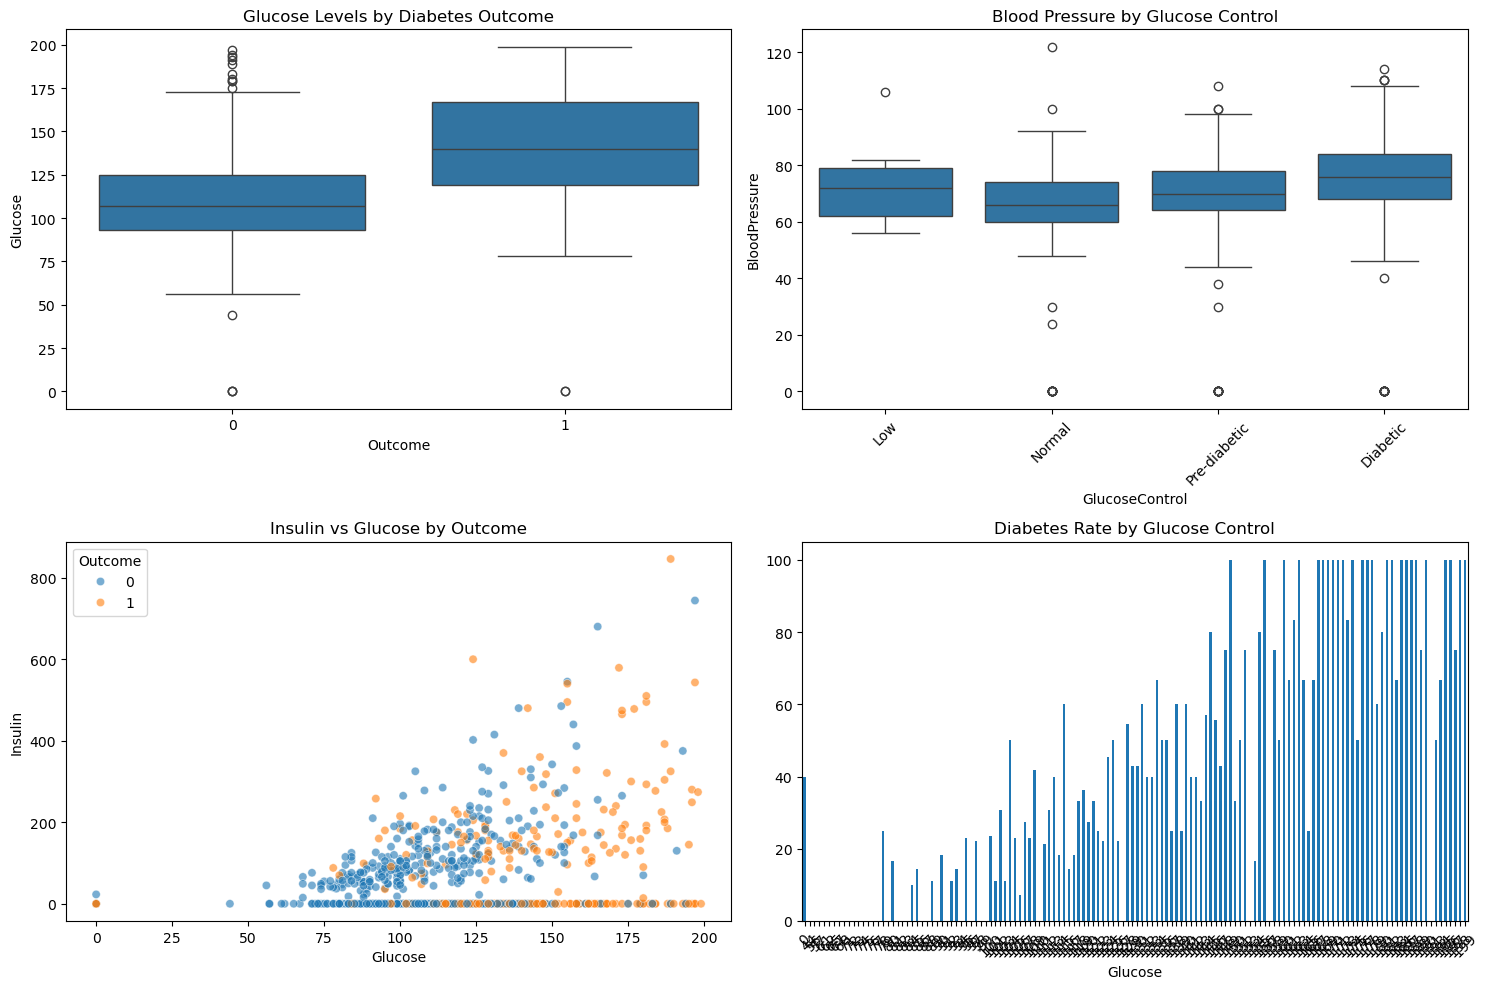

In [7]:
plt.figure(figsize=(15, 10))

# Glucose levels by outcome
plt.subplot(2, 2, 1)
sns.boxplot(x='Outcome', y='Glucose', data=df)
plt.title('Glucose Levels by Diabetes Outcome')

# Blood pressure distribution
plt.subplot(2, 2, 2)
sns.boxplot(x='GlucoseControl', y='BloodPressure', data=df)
plt.title('Blood Pressure by Glucose Control')
plt.xticks(rotation=45)

# Insulin vs Glucose
plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x='Glucose', y='Insulin', hue='Outcome', alpha=0.6)
plt.title('Insulin vs Glucose by Outcome')

# Outcome rate by glucose control
plt.subplot(2, 2, 4)
glucose_outcome = df.groupby('Glucose', observed=True)['Outcome'].mean() * 100
glucose_outcome.plot(kind='bar')
plt.title('Diabetes Rate by Glucose Control')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 7. Treatment Recommendations

In [8]:
def generate_treatment_recommendations(df, metrics_comparison):
    """Generate treatment recommendations based on analysis"""
    recommendations = []
    
    # Glucose control recommendations
    glucose_threshold = metrics_comparison.loc['Glucose', 'Difference_%']
    recommendations.append(
        f"Monitor glucose levels closely - {glucose_threshold:.1f}% "
        f"higher in diabetic patients"
    )
    
    # Blood pressure management
    bp_threshold = metrics_comparison.loc['BloodPressure', 'Difference_%']
    if abs(bp_threshold) > 5:
        recommendations.append(
            f"Include blood pressure management in treatment plan - "
            f"{abs(bp_threshold):.1f}% difference in diabetic patients"
        )
    
    # Risk-based recommendations
    high_risk_rate = (df.loc[df['RiskGroup'] == 'Very High', 'Outcome'] == 1).mean() * 100
    recommendations.append(
        f"Intensive monitoring needed for Very High risk group - "
        f"{high_risk_rate:.1f}% diabetes rate"
    )
    
    return recommendations

recommendations = generate_treatment_recommendations(df, metrics_comparison)
print("\nTreatment Recommendations:")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")


Treatment Recommendations:
1. Monitor glucose levels closely - 28.4% higher in diabetic patients
2. Intensive monitoring needed for Very High risk group - 84.4% diabetes rate


In [9]:

## 8. Outcome Summary

print("\nTreatment Outcome Summary:")
print(f"Overall diabetes rate: {(df['Outcome'] == 1).mean()*100:.1f}%")
print(f"Patients with controlled glucose: {(df['Glucose'] == 'Normal').mean()*100:.1f}%")
print(f"High-risk patients requiring intensive monitoring: {(df['RiskGroup'] == 'Very High').mean()*100:.1f}%")


Treatment Outcome Summary:
Overall diabetes rate: 34.9%
Patients with controlled glucose: 0.0%
High-risk patients requiring intensive monitoring: 4.2%
